## Variational Autoencoder on Fashion MNIST dataset

In [3]:
# Importing necessary libraries

import os, sys, random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn.functional as fun
import torch.nn as nn 
import torch.utils.data

from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms
%matplotlib inline

In [4]:
# Defining the root directories and the data follder to import data

root = os.getcwd()
data_folder = os.path.join(root, 'data')
if not os.path.isdir(data_folder):
    os.mkdir(data_folder)

In [2]:
# Device

use_gpu = torch.cuda.is_available()
use_metal = torch.backends.mps.is_available()

if use_gpu:
	device = torch.device("cuda")
elif use_metal:
    device = torch.device("mps")
else:
	device = torch.device("cpu")

print('Using Device: {}'.format(device))

Using Device: mps


In [7]:
# Define data loading step

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(root=data_folder, train=True, download=True, transform=img_transform),
    batch_size=256, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST(root=data_folder, train=False, transform=img_transform),
    batch_size=32, shuffle=True)

len(train_loader), len(test_loader)

(235, 313)

In [11]:
# Convert vector to image
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x


# Display images, n=max number of images to show
def display_images(in_raw, out_raw, n=1):
    out_raw = out_raw[:n]
    if in_raw is not None:
        in_raw = in_raw[:n]
        in_pic = to_img(in_raw.cpu().data).view(-1, 28, 28)
        plt.figure(figsize=(18, 6))
        for i in range(n):
            plt.subplot(1,n,i+1)
            plt.imshow(in_pic[i])
            plt.axis('off')
    out_pic = to_img(out_raw.cpu().data).view(-1, 28, 28)
    plt.figure(figsize=(18, 6))
    for i in range(n):   
        plt.subplot(1,n,i+1)
        plt.imshow(out_pic[i])
        plt.axis('off')
    plt.show()

In [8]:
def loss_function(x_hat, x, mu, logvar, beta=1):
    #recon_loss = nn.functional.binary_cross_entropy(
    recon_loss = nn.functional.mse_loss(
        x_hat, x.view(-1, 784), reduction='sum'
    )
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

    return recon_loss + beta * KLD

In [9]:
class VAE(nn.Module):
    def __init__(self, d=50):
        super().__init__()
        self.d = d #latent dimension
        
        self.encoder = nn.Sequential(
            nn.Linear(784, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, d * 2) # we have mean and variance, each is d-dim vector
        )

        self.decoder = nn.Sequential(
            nn.Linear(d, d ** 2),
            nn.ReLU(),
            nn.Linear(d ** 2, 784),
            nn.Tanh()
        )

    def sampler(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.new_empty(std.size()).normal_()
            return eps.mul_(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu_logvar = self.encoder(x.view(-1, 784)).view(-1, 2, self.d)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.sampler(mu, logvar)
        return self.decoder(z), mu, logvar
    
    def generate(self, N=10):
        z = torch.randn((N, self.d)).to(device)
        gen_img = self.decoder(z)
        return gen_img

====> Test set loss: 535.5640


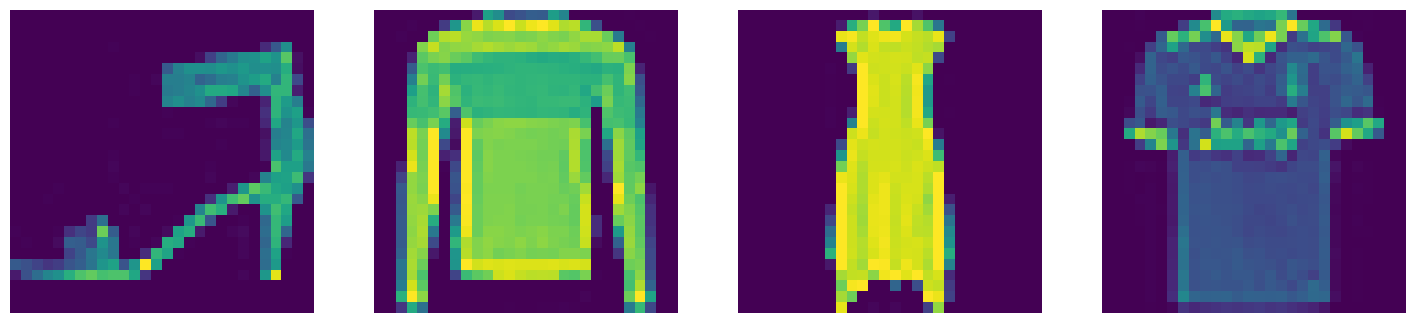

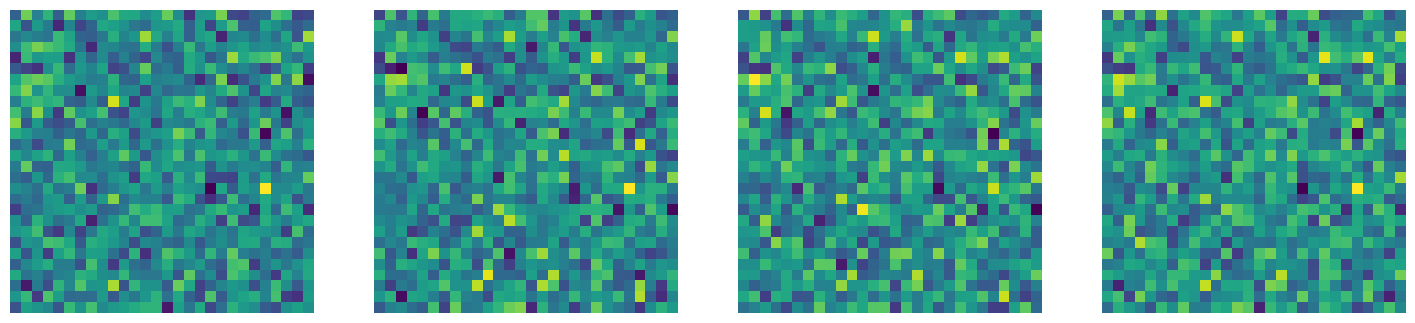

====> Epoch: 1 Average loss: 117.8162
====> Test set loss: 78.3871


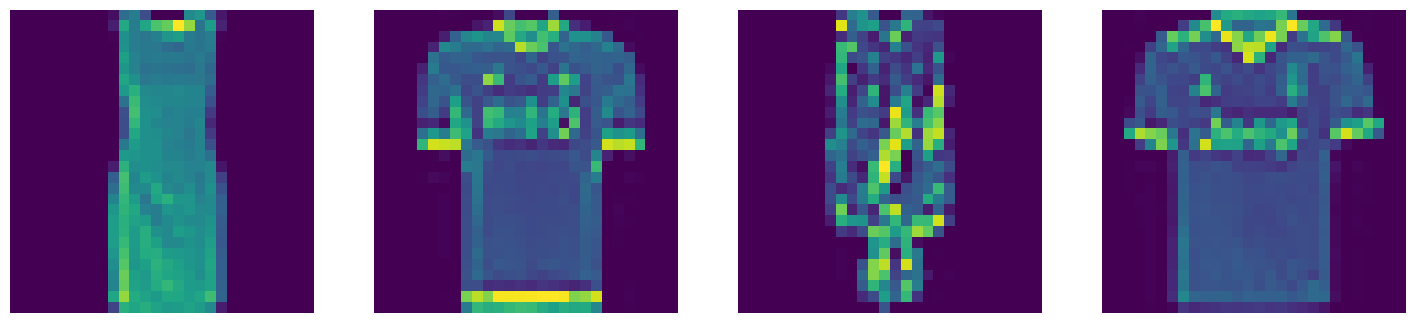

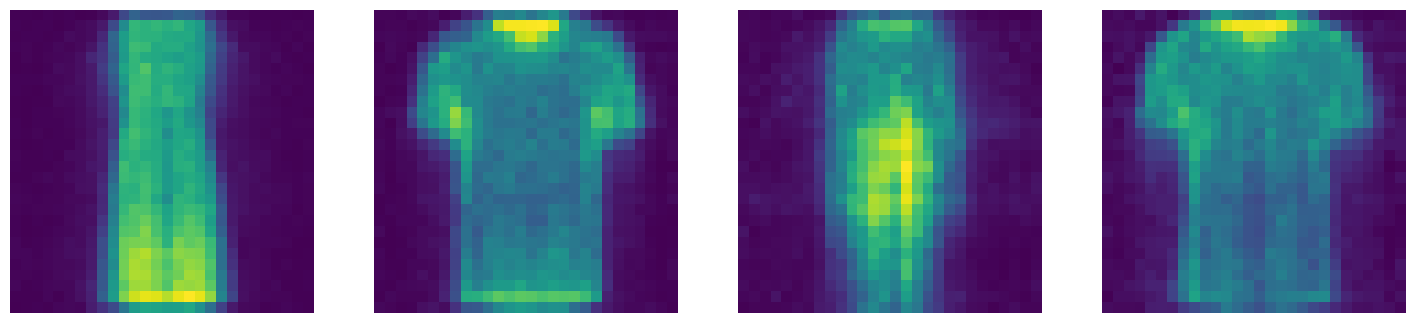

====> Epoch: 2 Average loss: 80.5195
====> Test set loss: 68.8499


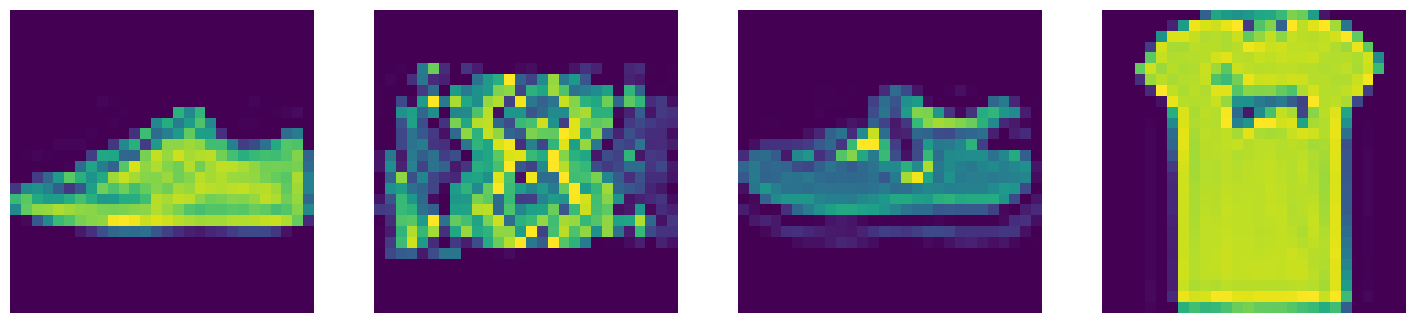

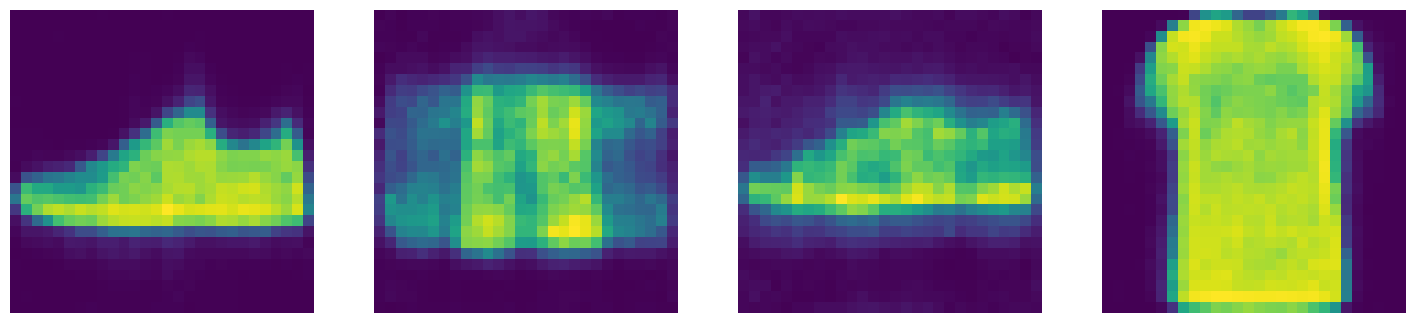

====> Epoch: 3 Average loss: 74.9010
====> Test set loss: 66.9583


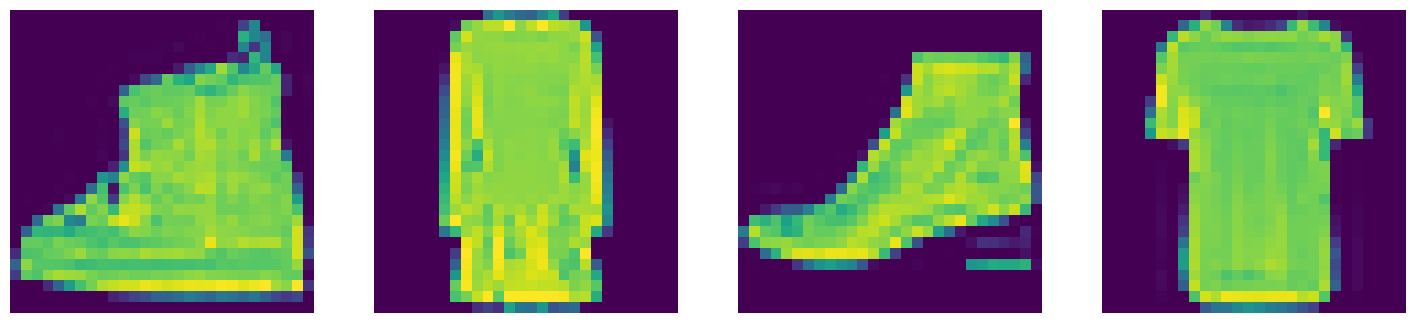

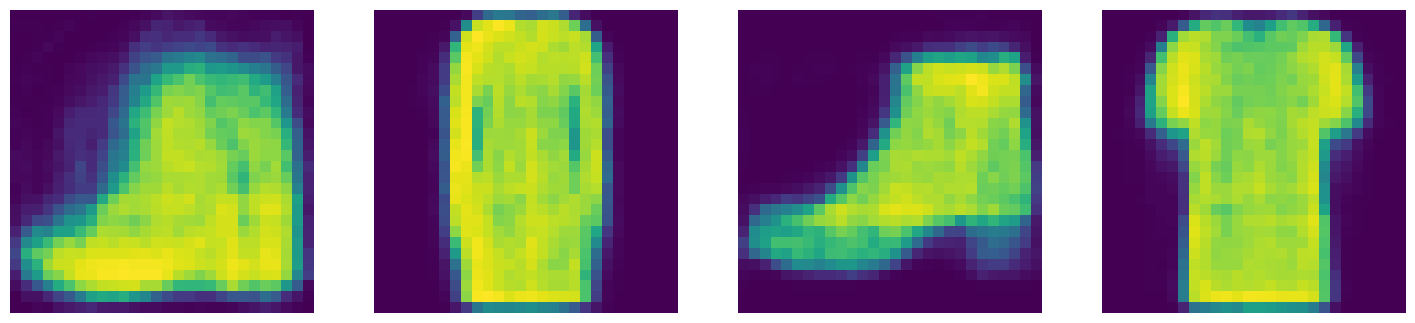

====> Epoch: 4 Average loss: 72.1190
====> Test set loss: 63.3599


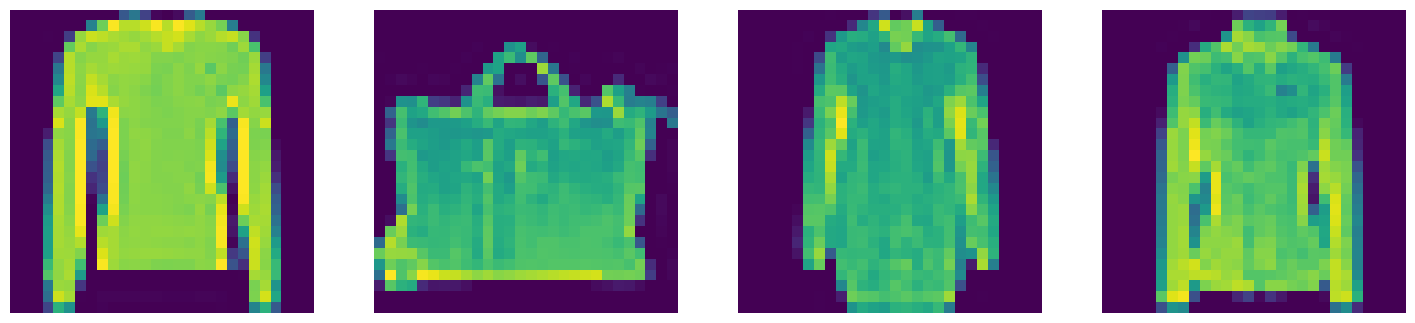

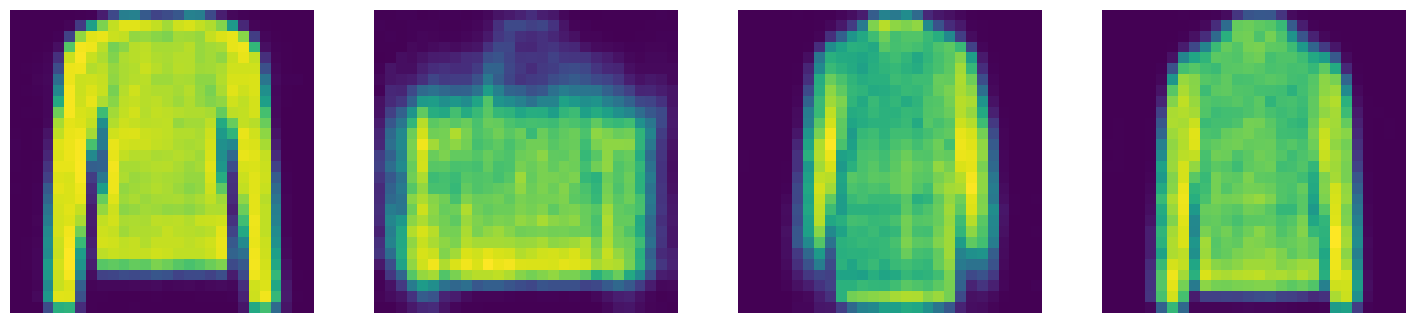

====> Epoch: 5 Average loss: 70.3657
====> Test set loss: 62.5424


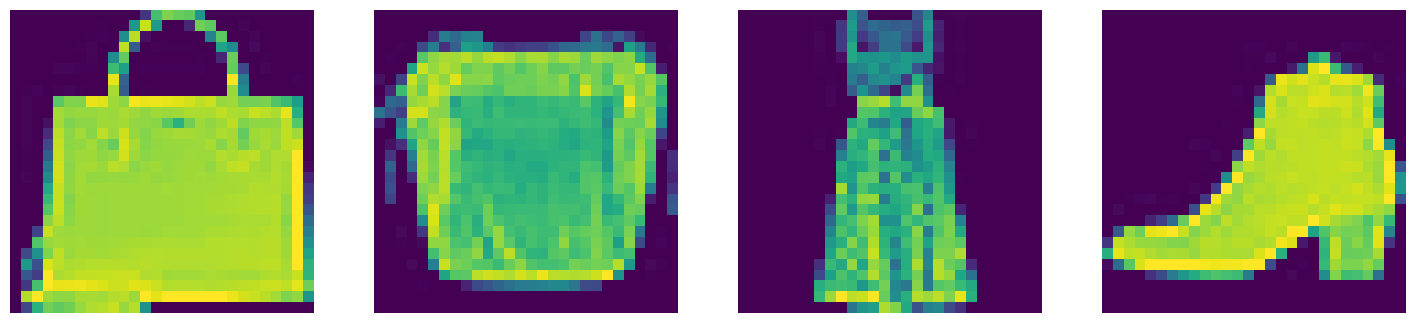

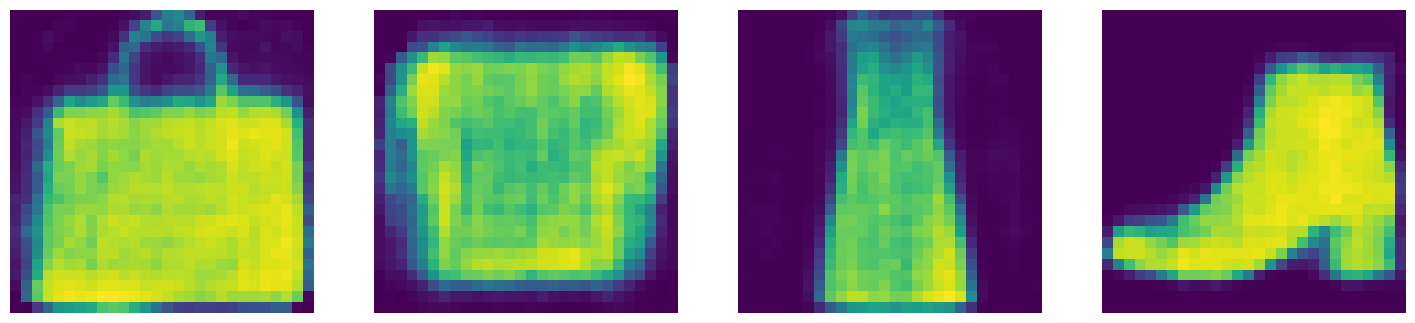

In [12]:
latent_dim=20
model = VAE(latent_dim).to(device)

# Setting the optimiser
learning_rate = 1e-3
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

epochs = 5
codes = dict(mu=list(), logσ2=list(), y=list())
for epoch in range(0, epochs + 1):
    # Training
    if epoch > 0:  # test untrained net first
        model.train()
        train_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            train_loss += loss.item()
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader):.4f}')
    
    # Testing
    means, logvars, labels = list(), list(), list()
    with torch.no_grad():
        model.eval()
        test_loss = 0
        for x, y in test_loader:
            x = x.to(device)
            # ===================forward=====================
            x_hat, mu, logvar = model(x)
            test_loss += loss_function(x_hat, x, mu, logvar).item()
            # =====================log=======================
            means.append(mu.detach())
            logvars.append(logvar.detach())
            labels.append(y.detach())
    # ===================log========================
    codes['mu'].append(torch.cat(means))
    codes['logσ2'].append(torch.cat(logvars))
    codes['y'].append(torch.cat(labels))
    test_loss /= len(test_loader)
    print(f'====> Test set loss: {test_loss:.4f}')
    display_images(x, x_hat, 4)